In [ ]:
NEURAL NETWORKS

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install scikeras

In [ ]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 8.2 MB/s eta 0:00:00


In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
# Instead of tensorflow.keras.wrappers.scikit_learn, use scikeras
from scikeras.wrappers import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
# Instead of keras.utils.vis_utils, use tensorflow.keras.utils
from tensorflow.keras.utils import plot_model

In [ ]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

In [ ]:
df = pd.read_csv("/content/cleanedcumalative.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [ ]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [ ]:

subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [ ]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [ ]:
X = StandardScaler().fit_transform(X)
#X = PCA().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [ ]:
def createModel():
    model = Sequential([
                    Dense(256, input_dim=X.shape[1], activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [ ]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=20, verbose=0)
    pred = model.predict(X_test)
    pred = pred >= 0.5
    f1 = f1_score(y_test, pred)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1

def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")

    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [ ]:
crossValidation(K=10)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 1 = 0.9705215419501134
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1 Score in fold 2 = 0.9790209790209791
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 3 = 0.9617977528089887
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 4 = 0.9690265486725663
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 5 = 0.9766355140186916
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 6 = 0.9834710743801653
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1 Score in fold 7 = 0.9748953974895398
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 8 = 0.9744680851063829
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 9 = 0.9836065573770492
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 10 = 0.9619686800894854
Average 10-Fold F1 Score = 0.9735412130913963

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 1 = 0.9846827133479212
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score in fold 2 = 0.9848156182212582
22/2

In [ ]:
model = createModel()
model.fit(X_train, y_train, epochs=20, verbose=0)
pred = model.predict(X_test)
pred = pred >= 0.5

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
performance(y_test, pred)

F1 Score: 0.980106100795756
Kappa Score: 0.9703405782335246
Accuracy Score: 0.9845193256210205
Confusion Matrix:
[[1521   13]
 [  17  739]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.98      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.99      0.98      0.99      2290
weighted avg       0.99      0.99      0.99      2290



In [ ]:
model_perm = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model_perm.fit(X, y)
perm = PermutationImportance(model_perm, random_state=0).fit(X,y)

In [ ]:
eli5.show_weights(perm, feature_names=TO_USE, top=None)

Weight,Feature
0.1377 ± 0.0049,koi_fpflag_ss
0.1286 ± 0.0043,koi_fpflag_co
0.0996 ± 0.0038,koi_fpflag_nt
0.0649 ± 0.0030,koi_fpflag_ec
0.0483 ± 0.0040,koi_duration
0.0469 ± 0.0041,koi_depth
0.0418 ± 0.0034,koi_teq
0.0401 ± 0.0039,koi_period
0.0273 ± 0.0047,koi_slogg
0.0173 ± 0.0015,koi_steff


In [ ]:
perm.feature_importances_

array([0.00074939, 0.00368929, 0.00291108, 0.1285776 , 0.04006341,
       0.00648508, 0.06487967, 0.13771437, 0.00550512, 0.09963972,
       0.02732382, 0.04182159, 0.00190229, 0.0483355 , 0.00438103,
       0.00830091, 0.04689437, 0.00141231, 0.01729356])

In [ ]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray(TO_USE)[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

In [ ]:
feature_importance_df.head()

,Features,Importance
0,koi_fpflag_ss,0.137714
1,koi_fpflag_co,0.128578
2,koi_fpflag_nt,0.099640
3,koi_fpflag_ec,0.064880
4,koi_duration,0.048335


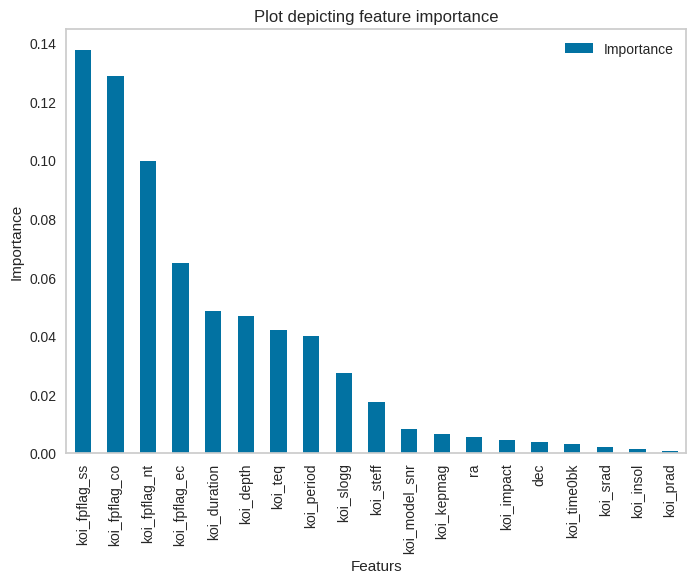

In [ ]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.grid()
plt.xlabel('Featurs')
plt.ylabel('Importance')
plt.savefig("feat_imp_nn.png", dpi=600)
plt.show()

In [ ]:
model = createModel()
x=plot_model(model, show_shapes=True)